Michael Fouts  
CHE 625  
February 22, 2023

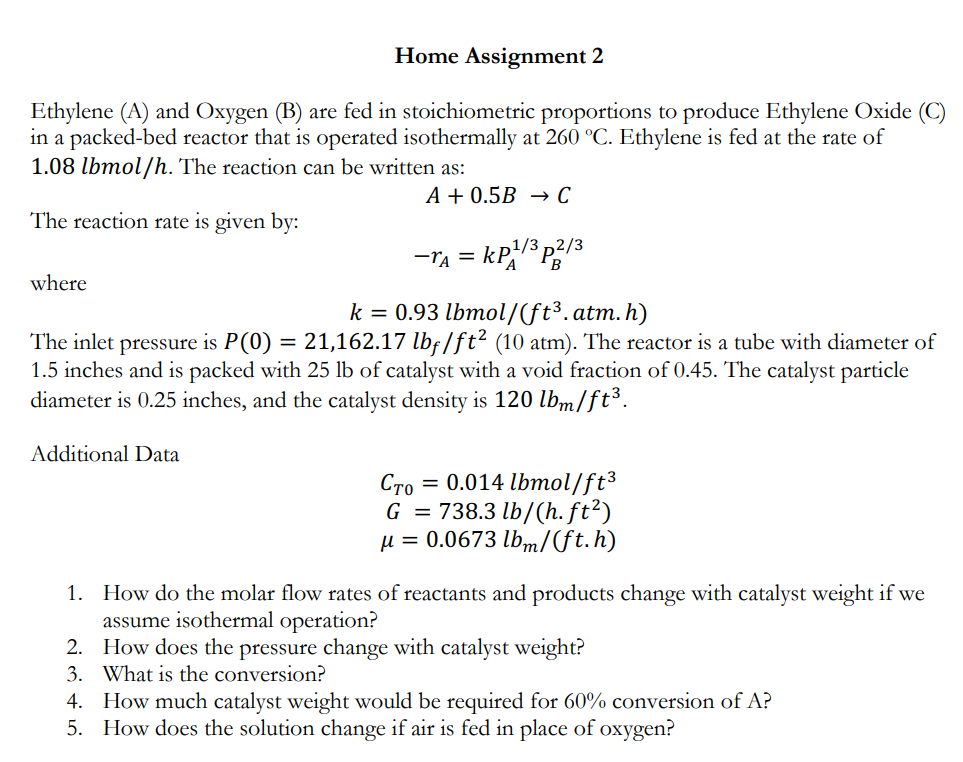

## Pre-Work

Before answering any of the questions, some pre-work must be done for this reaction.  The main considerations are evaluting the balances for each of the species and the pressure drop along the weight of catalyst in the reactor.  The written transcripts below reflect this derivation.

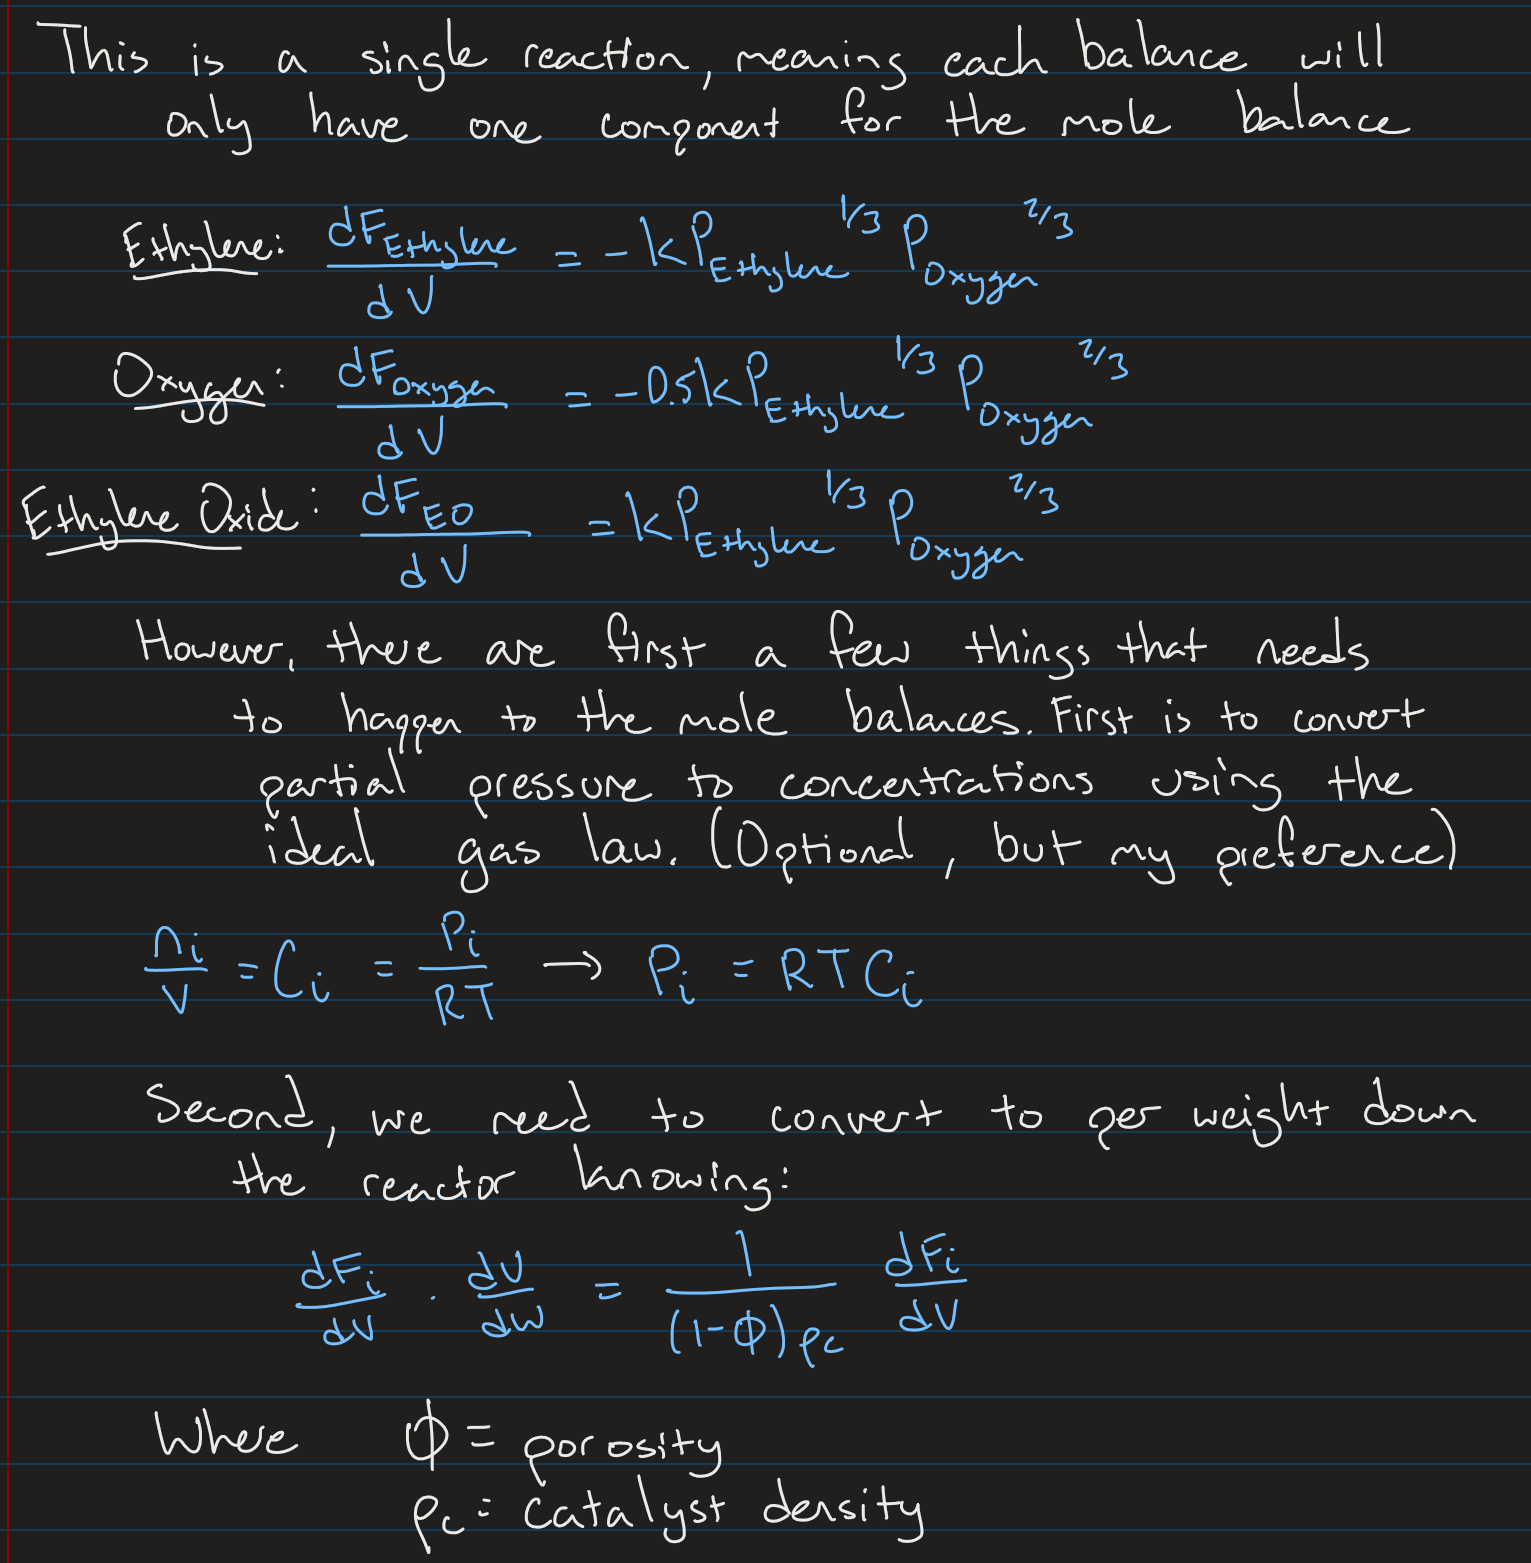

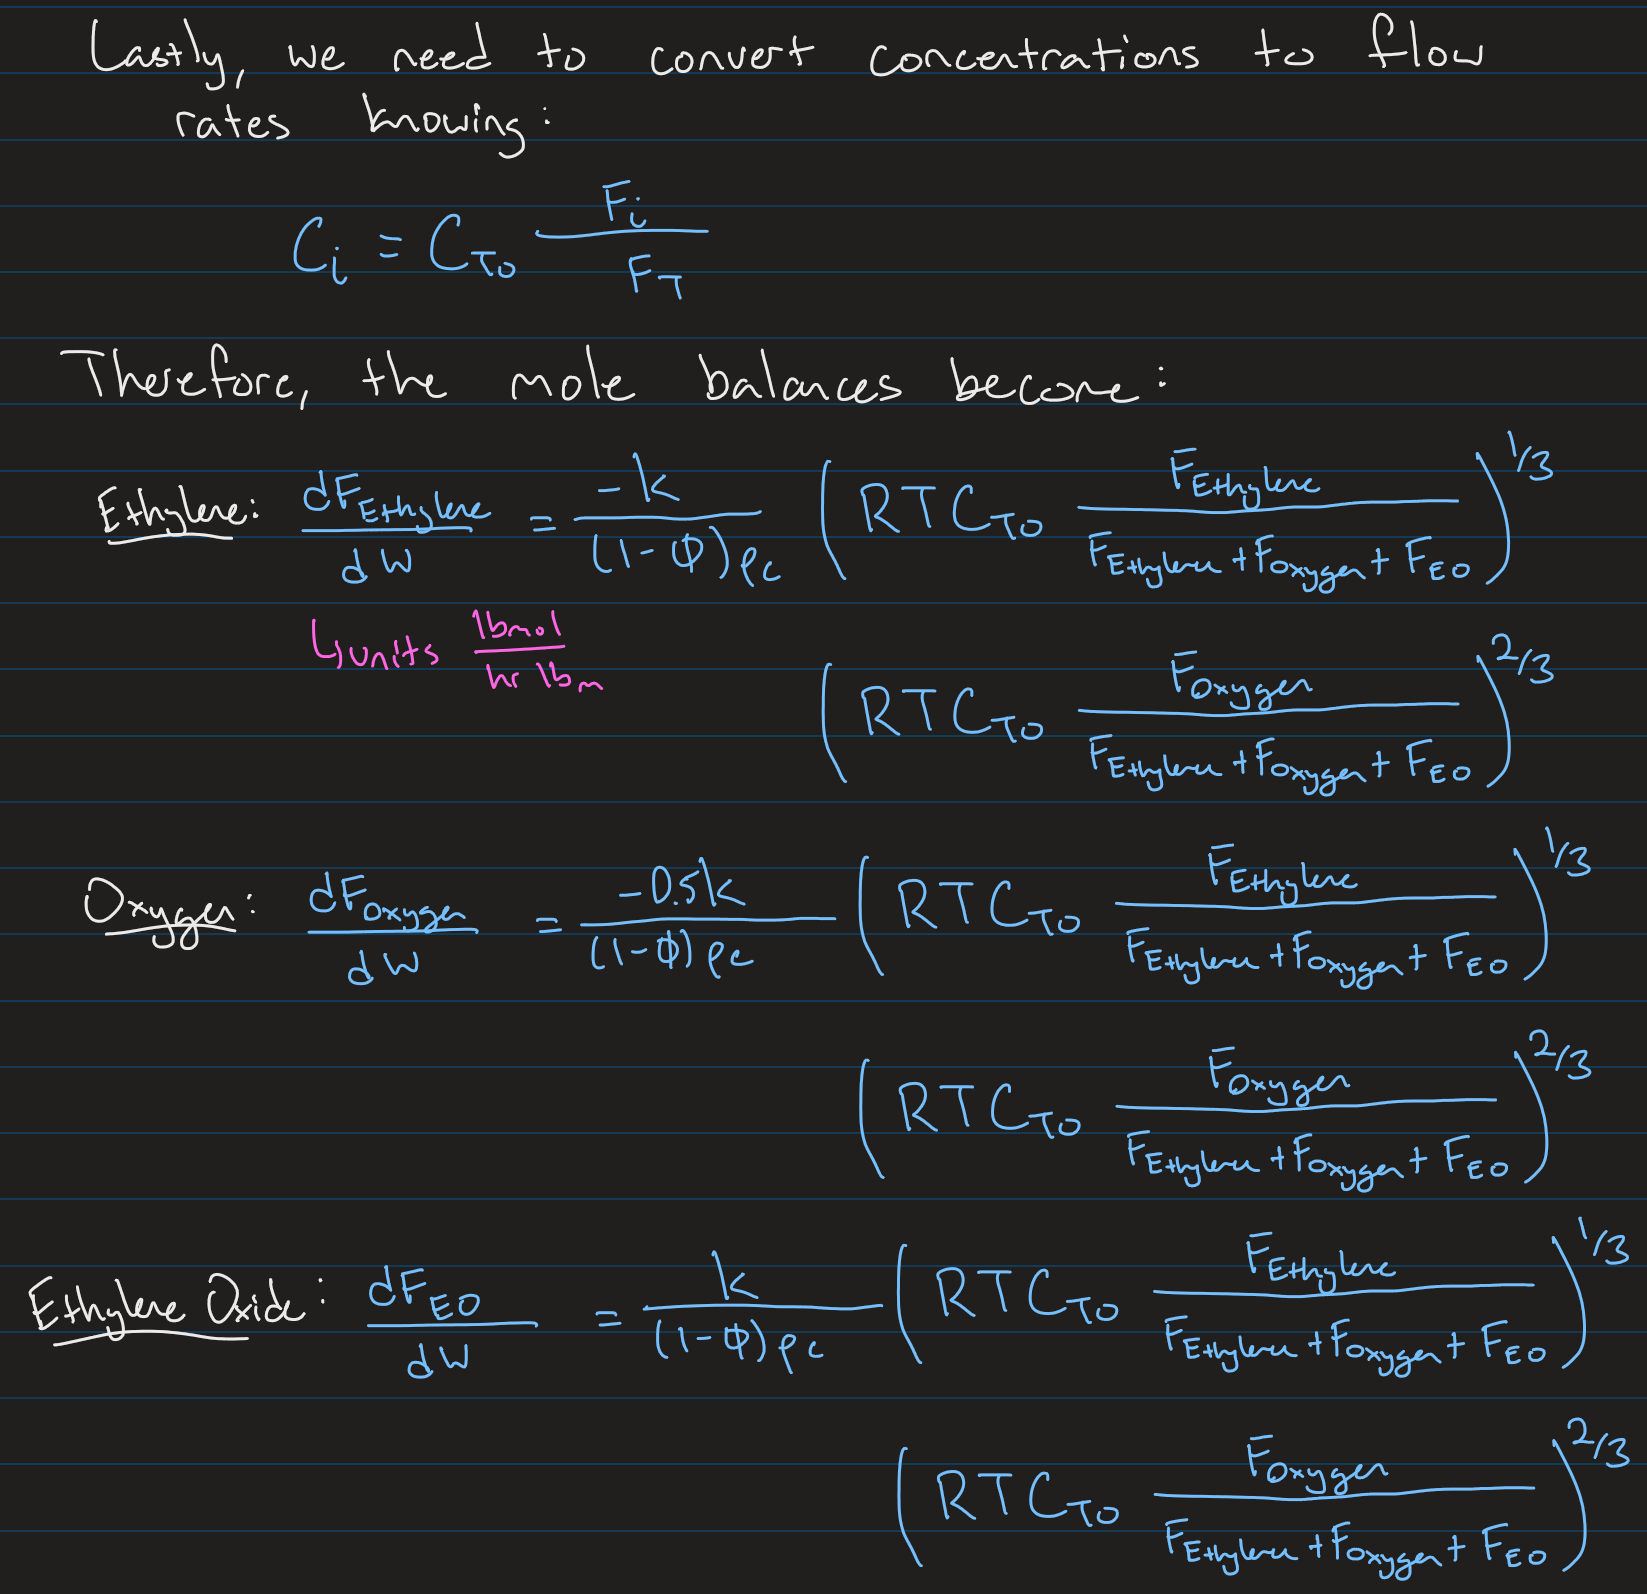

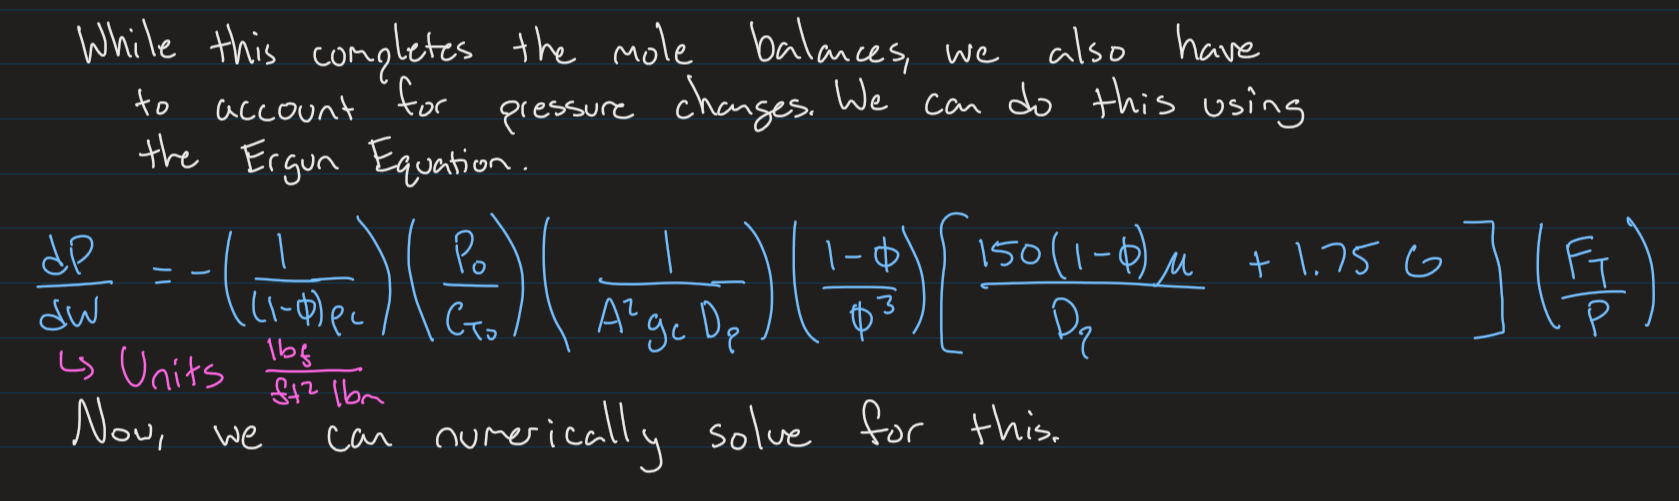

# Question 1
How do the molar flow rates of the reactants and products change with catylst weight if we assume isothermal operations?

For this we will need to solve the ODE's we derived above simultaneously.  Below is an implementation of that in python.

In [1]:
# Import relevant libraries

# For data processing
import math
import pandas as pd
import numpy as np

# For integration
from scipy.integrate import solve_ivp

# For visualizations
import seaborn as sns
sns.set_theme()
sns.set(rc={'figure.figsize':(11.7,8.27)})

To start, we need to define a function with the ODEs.  The function is written in the cell below and takes in w, the weight of catalyst along the reactor, and a vector called "changes" which is a list of four elements in this case where each corresponds to the current values of the variables in the ODEs.  The output of this function will be changes in each of the variables with respect to the change in weight of catalyst.

In [2]:
def dW(w,changes):
    '''
    This function takes in a weight as an independent variable and
    a list called changes as dependent variables and returns the
    incremental changes of the functions simulating the changing
    elements down the length of the reactor bed. This function
    is specific to ethylene and oxygen being turned into 
    ethylene oxide. 
    '''
    # Define constants
    k = 0.93 #lbmol/(ft3 atm h)
    phi = 0.45 # void fraction
    pc = 120 #lbm/ft3
    R = 0.730240507295273*1.8 # atm ft3/(lbmol °K)
    T = 260 + 273.15 # K
    Ct0 = 0.014 #lbmol/ft3
    P0 = 21162.17 #lbf/ft2
    A = math.pi*((1.5/12)**2)/4 # Cross Sectional Area in ft2
    Dp = 0.25/12 # ft
    gc = 4.17*10**8 #lbm ft / (h2 lbf)
    G = 738.3 #lbm/(h ft2)
    mu = 0.0673 #lbm/(ft h)

    # Reference for changes list
    # changes[0] = Fethylene in lbmol/hr
    # changes[1] = Foxygen in lbmol/hr
    # changes[2] = Feo in lbmol/hr
    # changes[3] = Pressure in lbf/ft2

    # Change Equations
    dFethylene = -(k/((1-phi)*pc))*(((R*T*Ct0)*(changes[0]/(changes[0]+changes[1]+changes[2])))**(1/3))*\
                                   (((R*T*Ct0)*(changes[1]/(changes[0]+changes[1]+changes[2])))**(2/3))
    dFoxygen = -0.5*(k/((1-phi)*pc))*(((R*T*Ct0)*(changes[0]/(changes[0]+changes[1]+changes[2])))**(1/3))*\
                                    (((R*T*Ct0)*(changes[1]/(changes[0]+changes[1]+changes[2])))**(2/3))
    dFeo = (k/((1-phi)*pc))*(((R*T*Ct0)*(changes[0]/(changes[0]+changes[1]+changes[2])))**(1/3))*\
                            (((R*T*Ct0)*(changes[1]/(changes[0]+changes[1]+changes[2])))**(2/3))
    dP = -(1/((1-phi)*pc))*(P0/Ct0)*(1/((A**2)*gc*Dp))*((1-phi)/(phi**3))*(((150*(1-phi)*mu)/Dp)+(1.75*G)) \
          *(changes[0]+changes[1]+changes[2])/changes[3]

    return [dFethylene, dFoxygen, dFeo, dP]

To integrate, we need to use the solve_ivp function from scipy.  The BDF method uses an implicit multi-step variable-order method specifically good for stiff problems per the documentation which is why I chose it as a substiute for the MATLAB equivalent of ODE15s.

In [3]:
# min and max weight for integration
weight_span = [0, 25]
# weight_series specifies what weights to give results for each variable.
# Because of indexing in python starting at 0, you have to add a 1 to the
# max weight here.
weight_series = np.arange(0,25+1,1)

solution = solve_ivp(dW, #function
                     weight_span, #min and max weight for integration
                     [1.08, 1.08*0.5, 0, 21162.17], # initial conditions (Ethylene, Oxygen, EO, Pressure)
                     t_eval = weight_series,
                     method='BDF') # BDF accounts for stiffnesses that may be present similar to ODE15s

Next, lets view a table of the results from the calculations.

In [4]:
results = pd.DataFrame(solution.y.transpose())
results = pd.concat([pd.DataFrame(weight_series), results], axis=1)
results.columns = ['Weight','Ethylene','Oxygen','EO','Pressure']
results

,Weight,Ethylene,Oxygen,EO,Pressure
0,0,1.080000,0.540000,0.000000,21162.170000
1,1,1.022980,0.511490,0.057020,21149.671759
2,2,0.968035,0.484017,0.111965,21137.381838
3,3,0.915071,0.457535,0.164929,21125.246565
4,4,0.864154,0.432077,0.215846,21113.303179
5,5,0.815286,0.407643,0.264714,21101.551681
6,6,0.768466,0.384233,0.311534,21089.992069
7,7,0.723694,0.361847,0.356306,21078.624345
8,8,0.680914,0.340457,0.399086,21067.432191
9,9,0.639919,0.319959,0.440081,21056.355822


Finally, lets create a graph of the Flowrate of Each Species along the weight of catalyst in the reactor to finish Question 1.  We can see that along the weight of catalyst, the ethylene and oxygen flows are decreasing while the ethylene oxide flow is increasing in a reasonable and expected fashion.

[]

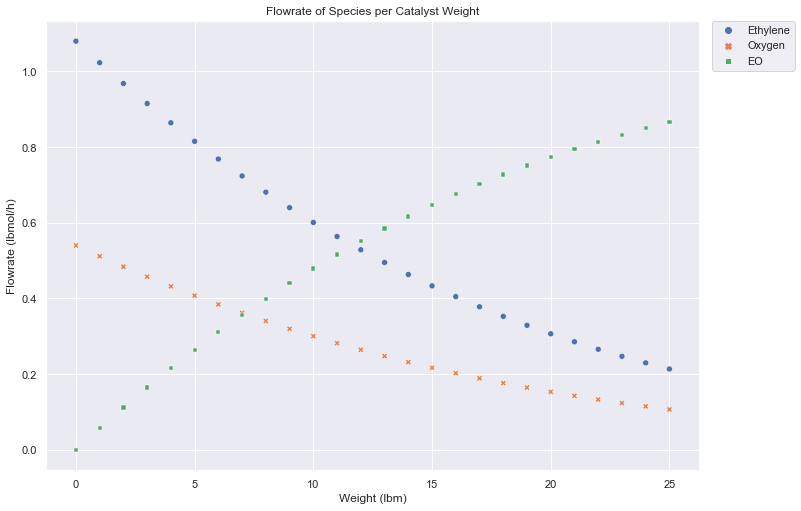

In [5]:
df_to_plot = pd.melt(frame = results.drop("Pressure", axis='columns'),
                     id_vars = 'Weight',
                     var_name = 'Variable',
                     value_name = 'Value')

plt = sns.scatterplot(data = df_to_plot, 
                      x = 'Weight', 
                      y = 'Value', 
                      style = 'Variable', 
                      hue = 'Variable')
plt.set(xlabel = 'Weight (lbm)',
        ylabel = 'Flowrate (lbmol/h)',
        title = 'Flowrate of Species per Catalyst Weight')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.plot()

# Question 2
How does the pressure change with catalyst weight?

This uses the same information derived in Question 1, just needing to plot it out.  It is very close to a linear decrease in pressure.

[]

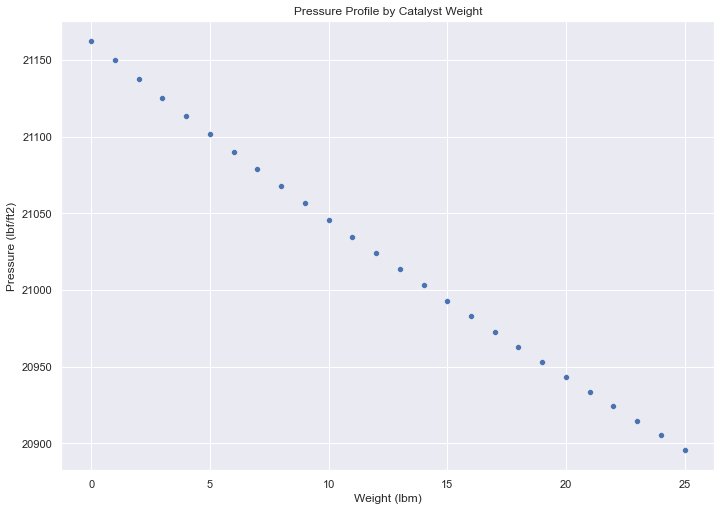

In [6]:
df_to_plot = pd.melt(frame = results,
                     id_vars = 'Weight',
                     var_name = 'Variable',
                     value_name = 'Value')

plt = sns.scatterplot(data = results, x = 'Weight', y = 'Pressure')
plt.set(xlabel = 'Weight (lbm)',
        ylabel = 'Pressure (lbf/ft2)',
        title = 'Pressure Profile by Catalyst Weight')
plt.plot()

# Question 3
What is the converstion?

Conversion is defined as the following:
$$
X = \frac{N_{A0} - N_A}{N_{A0}}
$$
where N is the number of moles.  In this case, we take Ethylene and by finding the number of moles reacted to the number of moles intially fed, we can caluclate the conversion.

In [7]:
conversion = (results['Ethylene'][0]-results['Ethylene'].tail(1).item())/results['Ethylene'][0]*100
print('The conversion is', round(conversion,2), '%')

The conversion is 80.22 %


# Question 4:
How much catalyst weight would be required for 60% conversion of A (Ethylene)?

For this, because the conversion was greater than 60%, I can take the data I already gathered and then linearly interpolate between the weights where the conversion was slightly above and below 60%.

In [8]:
# Find amount of Ethylene that is needed for 60% conversion
convert_60 = 1.08*(1-0.60)
print('The amount of Ethylene left needed for 60% conversion is', round(convert_60,3), 'lbmol/hr')

The amount of Ethylene left needed for 60% conversion is 0.432 lbmol/hr


In [9]:
# This code block is just linear interpolation of the data points previously shown to find the right amount of Ethylene left
bottom_bound = results[(results.Ethylene > convert_60)]
bottom_weight = bottom_bound.query('Ethylene==Ethylene.min()')['Weight'].values[0]

top_bound = results[(results.Ethylene < convert_60)]
top_weight = top_bound.query('Ethylene==Ethylene.max()')['Weight'].values[0]

weight = ((convert_60 - bottom_bound.Ethylene.min()) / \
(top_bound.Ethylene.max() - bottom_bound.Ethylene.min())) * \
(top_weight - bottom_weight) + bottom_weight

print('The weight of catalyst needed for 60% conversion is', round(weight,2), 'lbm')

The weight of catalyst needed for 60% conversion is 15.05 lbm


# Question 5
How does the solution change if air is fed in place of oxygen?

**NOTE:** I'm assuming when the question asks how does the "solution" change, I'm taking that as answering Question 4 with the catalyst weight.  If you are looking for something else, please refer to the intermediate values in the produced table. 

To solve for this, minor changes will need to be made to the previous code.  An additional value will need to be added to our "changes" vector that takes into account Nitrogen.  This will have an ODE equal to zero because it isn't changing but the flow will have to be added to the total flows.

In [10]:
def dW(w,changes):
    '''
    This function takes in a weight as an independent variable and
    a list called changes as dependent variables and returns the
    incremental changes of the functions simulating the changing
    elements down the length of the reactor bed. This function
    is specific to ethylene and oxygen being turned into 
    ethylene oxide. 
    '''
    # Define constants
    k = 0.93 #lbmol/(ft3 atm h)
    phi = 0.45 # void fraction
    pc = 120 #lbm/ft3
    R = 0.730240507295273*1.8 # atm ft3/(lbmol °K)
    T = 260 + 273.15 # K
    Ct0 = 0.014 #lbmol/ft3
    P0 = 21162.17 #lbf/ft2
    A = math.pi*((1.5/12)**2)/4 # Cross Sectional Area in ft2
    Dp = 0.25/12 # ft
    gc = 4.17*10**8 #lbm ft / (h2 lbf)
    G = 738.3 #lbm/(h ft2)
    mu = 0.0673 #lbm/(ft h)

    # Reference for changes list
    # changes[0] = Fethylene in lbmol/hr
    # changes[1] = Foxygen in lbmol/hr
    # changes[2] = Feo in lbmol/hr
    # changes[3] = Pressure in lbf/ft2
    # changes[4] = Fnitrogen in lbmol/hr

    # Change Equations
    dFethylene = -(k/((1-phi)*pc))*(((R*T*Ct0)*(changes[0]/(changes[0]+changes[1]+changes[2]+changes[4])))**(1/3))*\
                                   (((R*T*Ct0)*(changes[1]/(changes[0]+changes[1]+changes[2]+changes[4])))**(2/3))
    dFoxygen = -0.5*(k/((1-phi)*pc))*(((R*T*Ct0)*(changes[0]/(changes[0]+changes[1]+changes[2]+changes[4])))**(1/3))*\
                                    (((R*T*Ct0)*(changes[1]/(changes[0]+changes[1]+changes[2]+changes[4])))**(2/3))
    dFeo = (k/((1-phi)*pc))*(((R*T*Ct0)*(changes[0]/(changes[0]+changes[1]+changes[2]+changes[4])))**(1/3))*\
                            (((R*T*Ct0)*(changes[1]/(changes[0]+changes[1]+changes[2]+changes[4])))**(2/3))
    dP = -(1/((1-phi)*pc))*(P0/Ct0)*(1/((A**2)*gc*Dp))*((1-phi)/(phi**3))*(((150*(1-phi)*mu)/Dp)+(1.75*G)) \
          *(changes[0]+changes[1]+changes[2]+changes[4])/changes[3]
    dFnitrogen = 0

    return [dFethylene, dFoxygen, dFeo, dP, dFnitrogen]

I'm writing this code with foresight in mind and I found that 25 lbm doesn't give 60% conversion so I'm changing the range to 50 lbm so I can do the interpolation later on.  If you are curious of intermediate results, please refer to the table.

In [11]:
weight_span = [0, 50]
weight_series = np.arange(0,50+1,1)

solution = solve_ivp(dW, #function
                     weight_span, #min and max weight for integration
                     [1.08, 1.08*0.5, 0, 21162.17,1.08*0.5/0.21*0.79], # initial condition
                     t_eval = weight_series,
                     method='BDF') # BDF accounts for stiffnesses that may be present similar to ODE15s

In [12]:
results = pd.DataFrame(solution.y.transpose())
results = pd.concat([pd.DataFrame(weight_series), results], axis=1)
results.columns = ['Weight','Ethylene','Oxygen','EO','Pressure','Nitrogen']
results

,Weight,Ethylene,Oxygen,EO,Pressure,Nitrogen
0,0,1.080000,0.540000,0.000000,21162.170000,2.031429
1,1,1.054508,0.527254,0.025492,21133.788410,2.031429
2,2,1.029521,0.514760,0.050479,21105.465083,2.031429
3,3,1.005040,0.502520,0.074960,21077.199336,2.031429
4,4,0.981067,0.490533,0.098933,21048.991897,2.031429
5,5,0.957578,0.478789,0.122422,21020.836873,2.031429
6,6,0.934583,0.467292,0.145417,20992.736484,2.031429
7,7,0.912077,0.456038,0.167923,20964.689449,2.031429
8,8,0.890038,0.445019,0.189962,20936.690941,2.031429
9,9,0.868466,0.434233,0.211534,20908.740932,2.031429


For visualization purposes, I've included the graphs here as well.

[]

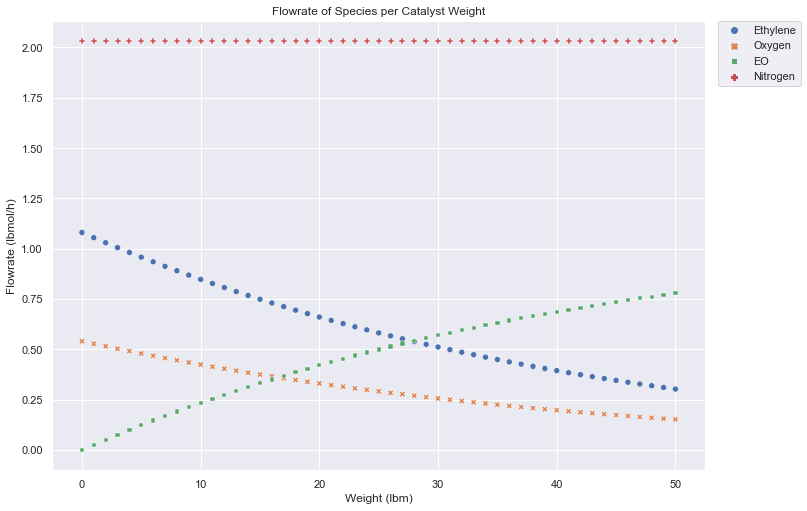

In [13]:
df_to_plot = pd.melt(frame = results.drop("Pressure", axis='columns'),
                     id_vars = 'Weight',
                     var_name = 'Variable',
                     value_name = 'Value')

plt = sns.scatterplot(data = df_to_plot, 
                      x = 'Weight', 
                      y = 'Value', 
                      style = 'Variable', 
                      hue = 'Variable')
plt.set(xlabel = 'Weight (lbm)',
        ylabel = 'Flowrate (lbmol/h)',
        title = 'Flowrate of Species per Catalyst Weight')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.plot()

[]

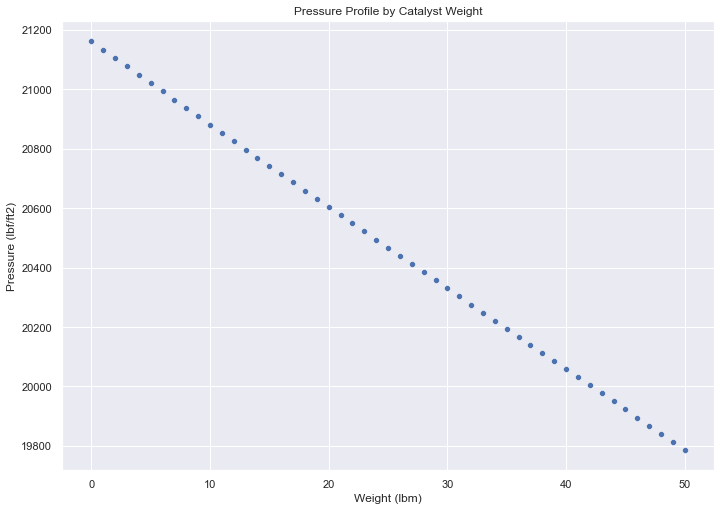

In [14]:
df_to_plot = pd.melt(frame = results,
                     id_vars = 'Weight',
                     var_name = 'Variable',
                     value_name = 'Value')

plt = sns.scatterplot(data = results, x = 'Weight', y = 'Pressure')
plt.set(xlabel = 'Weight (lbm)',
        ylabel = 'Pressure (lbf/ft2)',
        title = 'Pressure Profile by Catalyst Weight')
plt.plot()

In [15]:
conversion = (results['Ethylene'][0]-results['Ethylene'].tail(1).item())/results['Ethylene'][0]*100
print('The conversion is', round(conversion,2), '%')

convert_60 = 1.08*(1-0.60)

The conversion is 72.03 %


In [16]:
bottom_bound = results[(results.Ethylene > convert_60)]
bottom_weight = bottom_bound.query('Ethylene==Ethylene.min()')['Weight'].values[0]

top_bound = results[(results.Ethylene < convert_60)]
top_weight = top_bound.query('Ethylene==Ethylene.max()')['Weight'].values[0]

weight = ((convert_60 - bottom_bound.Ethylene.min()) / \
(top_bound.Ethylene.max() - bottom_bound.Ethylene.min())) * \
(top_weight - bottom_weight) + bottom_weight

print('The weight of catalyst needed for 60% conversion is', round(weight,2), 'lbm')

The weight of catalyst needed for 60% conversion is 36.46 lbm


We can see that the amount of catalyst needed greatly increases because the partial pressure (concentration) of all the components decreases creating a slower reaction.  In a real world design, this would have to be an economic optimization between the additional reactor/compression/other costs associated with more mass and that of buying pure oxygen.